# Desafío - Regularización

● En esta ocasión utilizaremos datos de la composición química de muestras de vino.

● Nuestro propósito será tratar de predecir su calidad a partir de su composición química.

# Ejercicio 1: Preparación del Ambiente de Trabajo

    ● Importe las librerías básicas.
    ● Importe los métodos asociados a regularización.
    ● Importe la base de datos.

In [1]:
path_colab = "/content/drive/MyDrive/Data Scientist/Desafío Latam/3 .-Machine Learning/1 .-Métodos de regularización lineal y expansiones basales/Desafios/winequality-red.csv"
path_casita = "winequality-red.csv"

#Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Librerías asociadas a regularización y separación de muestras
from sklearn.linear_model import  RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
#Librerías asociadas a medir el desempeño de los modelos
from sklearn.metrics import median_absolute_error, mean_squared_error #recordar que si usamos squared =False, tendrémos RMSE


df = pd.read_csv(path_casita)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**Comentario** 

De forma adicional, se muestra que no tenemos nulos en el dataframe

# Ejercicio 2: Análisis exploratorio


## a) Identifique el tipo de datos de cada columna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.quality.value_counts(normalize = True).sort_index()*100

3     0.625391
4     3.314572
5    42.589118
6    39.899937
7    12.445278
8     1.125704
Name: quality, dtype: float64

## b) Identifique outliers univariados y multivariados

Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos

### Análisis Univariado

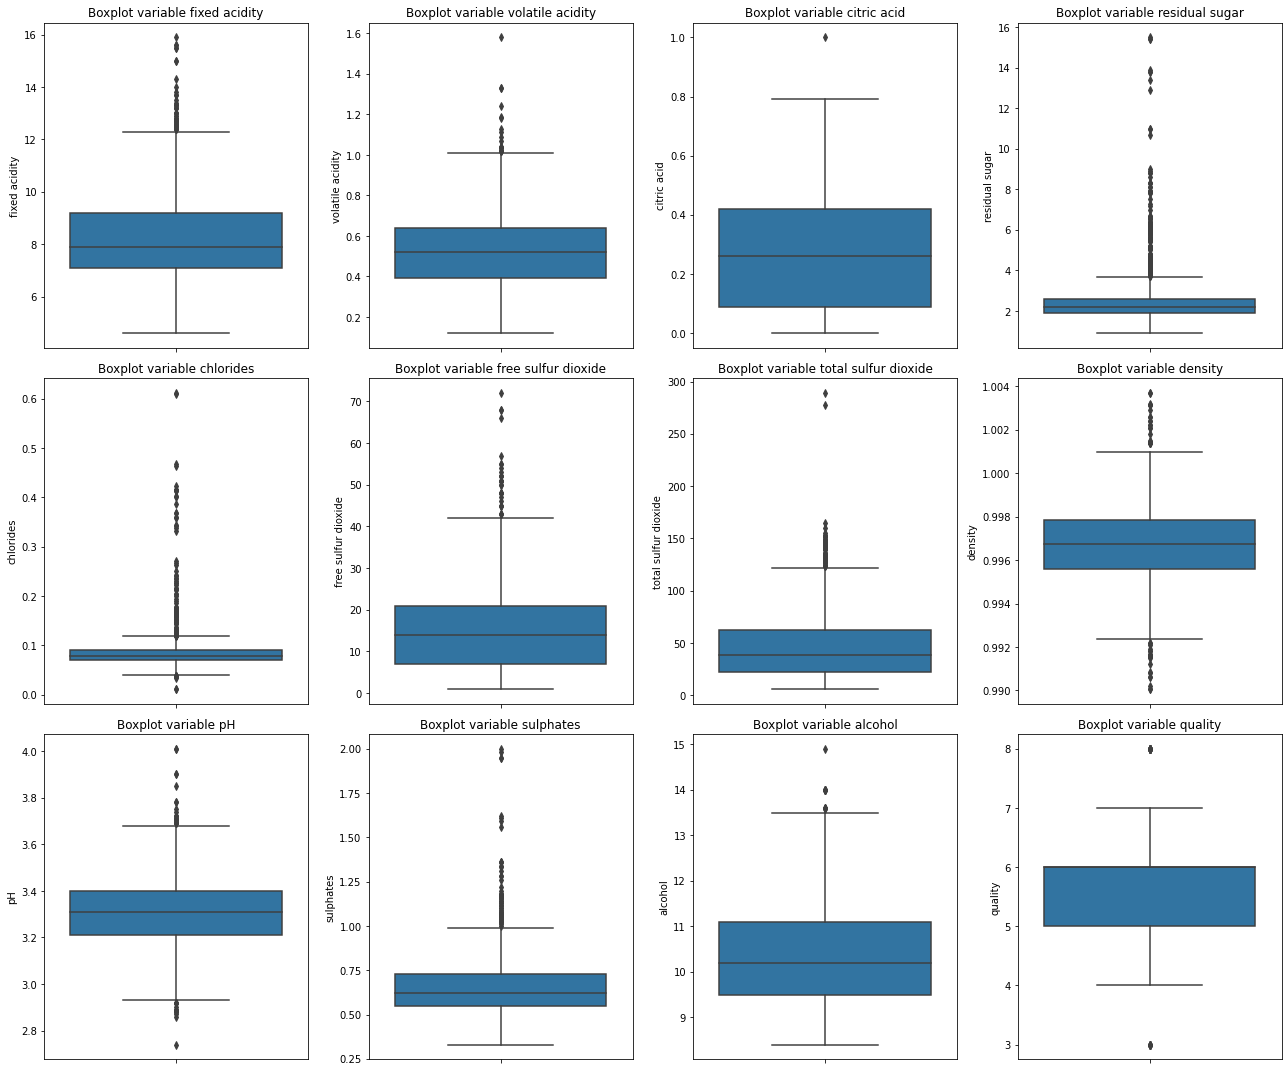

In [5]:
#Primero creamos nuestros subplots
fig, axes = plt.subplots(3, 4, figsize=(18, 15))

#iteramos por cada variable para genera cada plot por cada variable
j = 0
k = 0
for i in df.columns:
    sns.boxplot(y = df[i],
                ax=axes[j, k]
    )
    axes[j,k].set_title(f"Boxplot variable {i}")
    k += 1
    if k == 4:
      k =  0
      j += 1
plt.tight_layout()

In [6]:
#Para identificar los outliers en un dataframe crearemos la función:

def identify_outliers(dataframe):

  #detect floats and ints variables
  listado_de_variables = list(dataframe.select_dtypes('float').columns) + list(dataframe.select_dtypes('int').columns)

  #create new_df that we will use as return for the function
  new_df = dataframe.copy()

  #for each variable in listado_de_variables create new column "VariableName_outs" with 1 if the value is a outlier and 0 if it is not
  for i in listado_de_variables:
    q1 = dataframe[i].quantile(0.25)
    q3 = dataframe[i].quantile(0.75)
    iqr = q3-q1
    fence = 1.5*iqr
    new_column = i+"_outs"
    new_df[new_column] = np.where((dataframe[i] > q3 + fence) | (dataframe[i] < q1-fence), 1, 0)
  
  #creamos una nueva columna que pueda decir si la fila completa tiene algún outlier o no
  new_df['any_outs'] = np.where(new_df.filter(regex=("_outs*")).sum(axis = 1) > 0, 1, 0)
  return new_df

identify_outliers(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,fixed acidity_outs,volatile acidity_outs,citric acid_outs,residual sugar_outs,chlorides_outs,free sulfur dioxide_outs,total sulfur dioxide_outs,density_outs,pH_outs,sulphates_outs,alcohol_outs,quality_outs,any_outs
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0,0,0,0,0,0,0,0,0,0,0,0,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
#Mostramos la cantidad de outliers por columna
print(identify_outliers(df).filter(regex = "_outs*").drop(columns = 'any_outs').sum().sort_values(ascending = False))

#También mostramos el porcentaje de outliers por columna
print(round(identify_outliers(df).filter(regex = "_outs*").drop(columns = 'any_outs').mean().sort_values(ascending = False),3))

residual sugar_outs          155
chlorides_outs               112
sulphates_outs                59
total sulfur dioxide_outs     55
fixed acidity_outs            49
density_outs                  45
pH_outs                       35
free sulfur dioxide_outs      30
quality_outs                  28
volatile acidity_outs         19
alcohol_outs                  13
citric acid_outs               1
dtype: int64
residual sugar_outs          0.097
chlorides_outs               0.070
sulphates_outs               0.037
total sulfur dioxide_outs    0.034
fixed acidity_outs           0.031
density_outs                 0.028
pH_outs                      0.022
free sulfur dioxide_outs     0.019
quality_outs                 0.018
volatile acidity_outs        0.012
alcohol_outs                 0.008
citric acid_outs             0.001
dtype: float64


**Comentario**

Notar que ninguna columna tiene más de un 10% de outliers, sin embargo, si quisiéramos eliminar las filas que tengan al menos un outlier, el resultado sería el siguiente:

In [8]:
identify_outliers(df)['any_outs'].mean()

0.2626641651031895

**Comentario**

Si quisieramos eliminar outliers de esta forma, tendríamos que eliminar un poco más del 26% del dataframe, lo cual es una cantidad importante

### Análsis Bivariado

Según lo conversado con el profesor durante la clase, sólo mostraremos los resultados más no se hará un trabajo para identificarlos

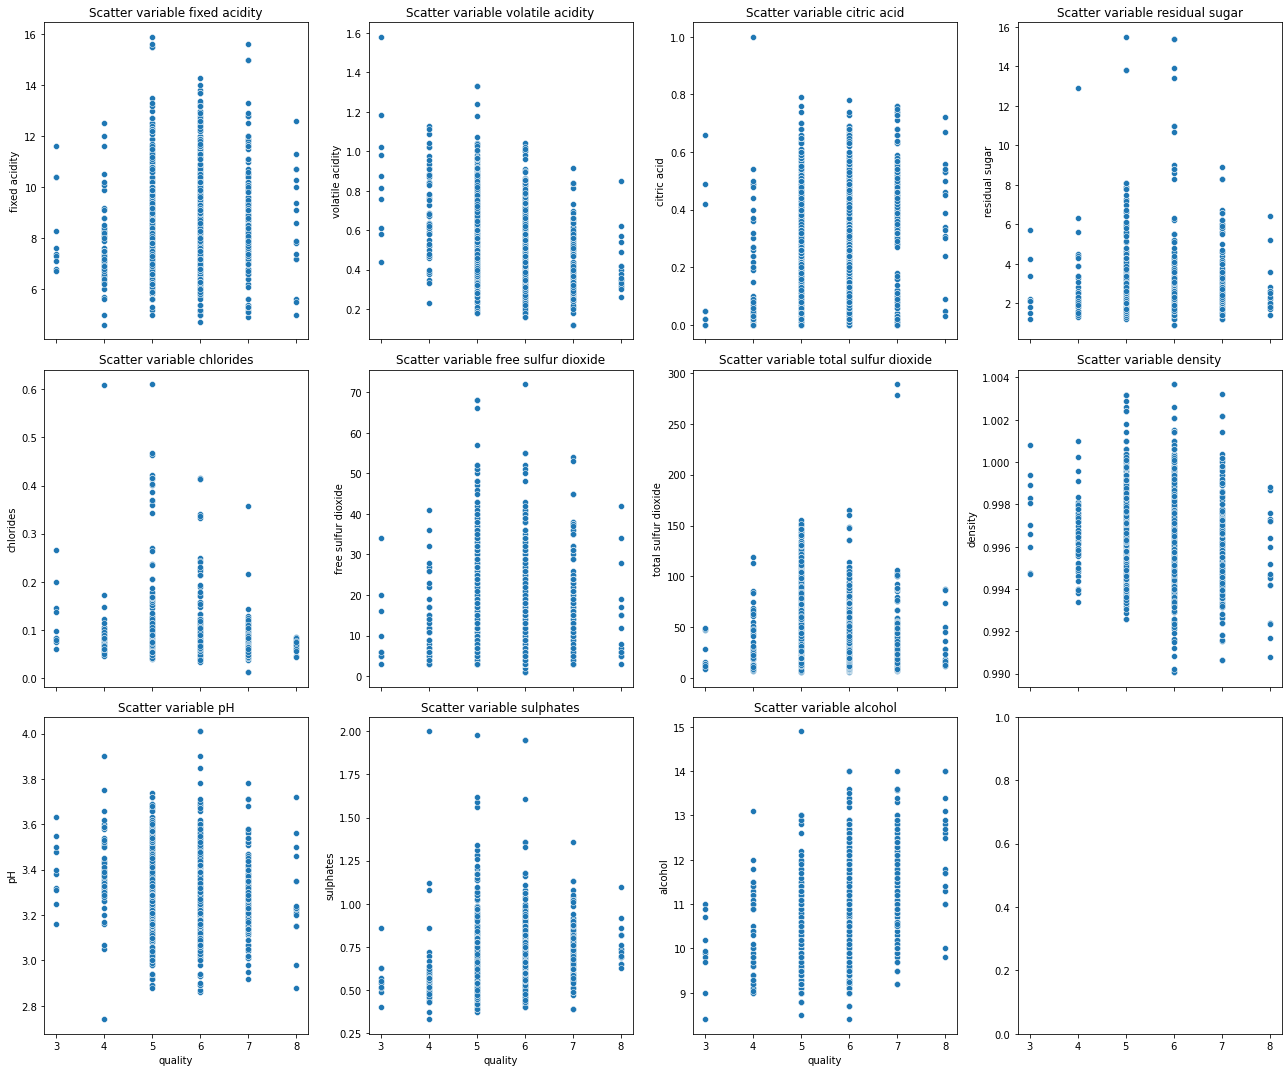

In [9]:
#Generamos un scatterplot para cada variable independiente versus el vector objetivo (variable dependiente)

#Primero creamos nuestros subplots
fig, axes = plt.subplots(3, 4, figsize=(18, 15), sharex=True)

#iteramos por cada variable para genera cada plot por cada variable
j = 0
k = 0
for i in df.drop(columns = 'quality').columns:
    sns.scatterplot(x = df['quality'],
                    y = df[i],
                    ax= axes[j, k]
    )
    axes[j,k].set_title(f"Scatter variable {i}")
    k += 1
    if k == 4:
      k =  0
      j += 1
plt.tight_layout()

# Ejercicio 3: Regularización de modelos

Genere tres modelos, correspondientes a​ RidgeCV, ​LassoCV y​ ElasticNetCV​. Para cada uno de ellos implemente los siguientes pasos:

    ○ Entrene los modelos con 10 validaciones cruzadas.
    ○ Extraiga los coeficientes estimados, el mejor valor alpha, MAE (​median_absolute_error​) y RMSE (raiz cuadrada de mean_squared_error​) asociado a cada modelo.
    ○ En base a la información solicitada, responda lo siguiente:
        ○ ¿Qué modelo presenta un mejor desempeño en base a las métricas?
        ○ ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

In [10]:
#Definimos los alphas
alphas = np.logspace(-3,3,25)
list(alphas)

[0.001,
 0.0017782794100389228,
 0.0031622776601683794,
 0.005623413251903491,
 0.01,
 0.01778279410038923,
 0.03162277660168379,
 0.05623413251903491,
 0.1,
 0.1778279410038923,
 0.31622776601683794,
 0.5623413251903491,
 1.0,
 1.7782794100389228,
 3.1622776601683795,
 5.623413251903491,
 10.0,
 17.78279410038923,
 31.622776601683793,
 56.23413251903491,
 100.0,
 177.82794100389228,
 316.22776601683796,
 562.341325190349,
 1000.0]

In [11]:
#Separamos nuestros datos en entrenamiento y testing
X = df.drop(columns = 'quality')
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [12]:
#generamos un dataframe para poder luego graficos la comparación entre los modelos

resultados = pd.DataFrame()

## a) RidgeCV

In [13]:
#instanceamos nuestro modelo y fiteamos
ridge = RidgeCV(cv= 10, alphas=alphas).fit(X_train, y_train)

#Predecimos el set de pruebas
y_pred = ridge.predict(X_test)

#generamos nuestros indicadores de desempeño
MAE = median_absolute_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred, squared=False)

#colocamos todo sobre el dataframe resultados
resultados = resultados.append({"model":"RidgeCV",
                                "BestAlpha":ridge.alpha_,
                                "coef00":ridge.coef_[0],"coef01":ridge.coef_[1],"coef02":ridge.coef_[2],"coef03":ridge.coef_[3],"coef04":ridge.coef_[4],"coef05":ridge.coef_[5],"coef06":ridge.coef_[6],"coef07":ridge.coef_[7],"coef08":ridge.coef_[8],"coef09":ridge.coef_[9],"coef10":ridge.coef_[10],
                                "MAE":MAE,"RMSE":RMSE}, ignore_index=True)
resultados

,BestAlpha,MAE,RMSE,coef00,coef01,coef02,coef03,coef04,coef05,coef06,coef07,coef08,coef09,coef10,model
0,1.0,0.420886,0.626856,0.019614,-1.021529,-0.16427,0.000624,-1.226774,0.005686,-0.003561,-0.011153,-0.376223,0.746956,0.297591,RidgeCV


## b) LassoCV

In [14]:
#instanceamos nuestro modelo y fiteamos
lasso = LassoCV(cv= 10, alphas=alphas).fit(X_train, y_train)

#Predecimos el set de pruebas
y_pred = lasso.predict(X_test)

#generamos nuestros indicadores de desempeño
MAE = median_absolute_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred, squared=False)

#colocamos todo sobre el dataframe resultados
resultados = resultados.append({"model":"LassoCV",
                                "BestAlpha":lasso.alpha_,
                                "coef00":lasso.coef_[0],"coef01":lasso.coef_[1],"coef02":lasso.coef_[2],"coef03":lasso.coef_[3],"coef04":lasso.coef_[4],"coef05":lasso.coef_[5],"coef06":lasso.coef_[6],"coef07":lasso.coef_[7],"coef08":lasso.coef_[8],"coef09":lasso.coef_[9],"coef10":lasso.coef_[10],
                                "MAE":MAE, "RMSE":RMSE}, ignore_index=True)
resultados

,BestAlpha,MAE,RMSE,coef00,coef01,coef02,coef03,coef04,coef05,coef06,coef07,coef08,coef09,coef10,model
0,1.000,0.420886,0.626856,0.019614,-1.021529,-0.164270,0.000624,-1.226774,0.005686,-0.003561,-0.011153,-0.376223,0.746956,0.297591,RidgeCV
1,0.001,0.420580,0.627953,0.017714,-0.988279,-0.077182,-0.000000,-1.221727,0.005817,-0.003626,-0.000000,-0.310294,0.728819,0.294120,LassoCV


## c) ElasticNetCV

In [15]:
#instanceamos nuestro modelo y fiteamos
elasticnet = ElasticNetCV(cv= 10, alphas=alphas).fit(X_train, y_train)

#Predecimos el set de pruebas
y_pred = elasticnet.predict(X_test)

#generamos nuestros indicadores de desempeño
MAE = median_absolute_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred, squared=False)

#colocamos todo sobre el dataframe resultados
resultados = resultados.append({"model":"ElasticNetCV",
                                "BestAlpha":elasticnet.alpha_,
                                "coef00":elasticnet.coef_[0],"coef01":elasticnet.coef_[1],"coef02":elasticnet.coef_[2],"coef03":elasticnet.coef_[3],"coef04":elasticnet.coef_[4],"coef05":elasticnet.coef_[5],"coef06":elasticnet.coef_[6],"coef07":elasticnet.coef_[7],"coef08":elasticnet.coef_[8],"coef09":elasticnet.coef_[9],"coef10":elasticnet.coef_[10],
                                "MAE":MAE,"RMSE":RMSE}, ignore_index=True)
resultados

,BestAlpha,MAE,RMSE,coef00,coef01,coef02,coef03,coef04,coef05,coef06,coef07,coef08,coef09,coef10,model
0,1.000,0.420886,0.626856,0.019614,-1.021529,-0.164270,0.000624,-1.226774,0.005686,-0.003561,-0.011153,-0.376223,0.746956,0.297591,RidgeCV
1,0.001,0.420580,0.627953,0.017714,-0.988279,-0.077182,-0.000000,-1.221727,0.005817,-0.003626,-0.000000,-0.310294,0.728819,0.294120,LassoCV
2,0.001,0.420874,0.627640,0.019305,-1.005679,-0.123526,0.000000,-1.161309,0.005751,-0.003581,-0.000000,-0.337042,0.729022,0.296601,ElasticNetCV


## d) ¿Qué modelo presenta un mejor desempeño en base a las métricas?

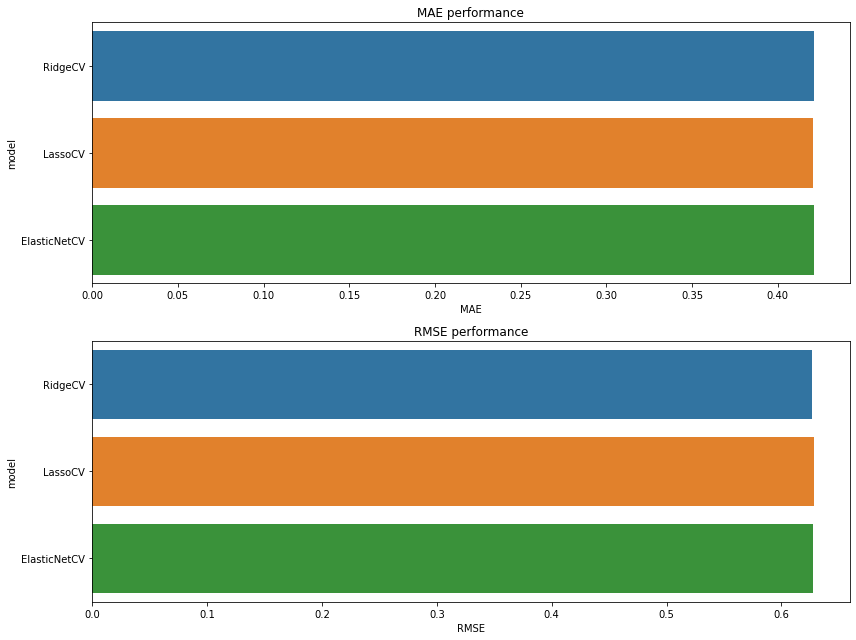

In [16]:
#graficamos la comparación de MAE

#Primero creamos nuestros subplots
fig, axis = plt.subplots(2, 1, figsize=(12, 9))

sns.barplot(
    orient = 'h',
    data = resultados,
    y = 'model',
    x = 'MAE',
    ax = axis[0]
    ).set_title("MAE performance")
sns.barplot(
    orient = 'h',
    data = resultados,
    y = 'model',
    x = 'RMSE',
    ax = axis[1]
    ).set_title("RMSE performance")
plt.tight_layout()

**Comentario**

Ninguno de los 3 tiene mejores métricas que los otros 2, sin embargo LassoCV es mejor en cuanto al MAE por tener el menor de los 3, pero por otro lado RidgeCV tiene el RMSE más bajo de los 3. Pero la verdad es que ninguno de los 3 resalta por sus rendimiento en comparación a los otros 2.

## e) ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

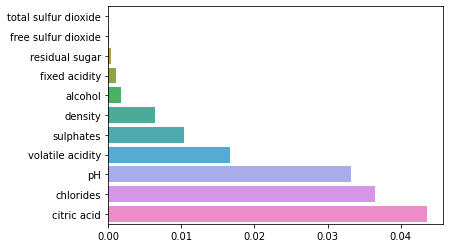

In [17]:
#¡grafiquemos de nuevo po!

coefs = pd.DataFrame(resultados.filter(regex = "coef")).rename(columns = {
    "coef00":df.columns[0],
    "coef01":df.columns[1],
    "coef02":df.columns[2],
    "coef03":df.columns[3],
    "coef04":df.columns[4],
    "coef05":df.columns[5],
    "coef06":df.columns[6],
    "coef07":df.columns[7],
    "coef08":df.columns[8],
    "coef09":df.columns[9],
    "coef10":df.columns[10],
    "coef11":df.columns[11],

}
)
sns.barplot(y = coefs.std(axis = 0).sort_values().index,
            x = coefs.std(axis = 0).sort_values().values,
            orient = 'h')

**Comentario**

'total sulfur dioxide', 'free sulfur dioxide' y 'residual sugar' son las 3 variables que presentan menor desviación estándar y por tanto variabilidad a lo largo de los 3 modelos.